In [114]:
# ensuring TensorFlow is properly installed and running locally
import tensorflow as tf
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

print(tf.__version__)

DIRECTORY_PATH = 'cifar-10-batches-py'

DIRECTORY_LABELS = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

2.20.0


In [115]:
# extract compressed data tar.gz
def load_cifar_batch(filename):
    with open(filename, 'rb') as file:
        data_dict = pickle.load(file, encoding='bytes')
        images = data_dict[b'data']
        labels = data_dict[b'labels']
    return images, labels

def load_all_batches(directory_path):
    images = []
    labels = []
    
    # Load all data batches
    for i in range(1, 6):
        batch_file = os.path.join(directory_path, f'data_batch_{i}')
        batch_images, batch_labels = load_cifar_batch(batch_file)
        
        images.append(batch_images)
        labels.extend(batch_labels)
    
    # Combine images and labels
    images = np.concatenate(images)
    labels = np.array(labels)
    
    return images, labels

train_images, train_labels = load_all_batches(DIRECTORY_PATH)

# Convert to DataFrame
train_data = pd.DataFrame({'image': list(train_images), 'label': train_labels})

In [116]:
# Load the test batch
test_batch_file = os.path.join(DIRECTORY_PATH, 'test_batch')
test_images, test_labels = load_cifar_batch(test_batch_file)

# Convert to DataFrame
test_data = pd.DataFrame({
    'Image': list(test_images),
    'Label': test_labels
})

In [117]:
print(train_data.head())
print(test_data.head())

                                               image  label
0  [59, 43, 50, 68, 98, 119, 139, 145, 149, 149, ...      6
1  [154, 126, 105, 102, 125, 155, 172, 180, 142, ...      9
2  [255, 253, 253, 253, 253, 253, 253, 253, 253, ...      9
3  [28, 37, 38, 42, 44, 40, 40, 24, 32, 43, 30, 3...      4
4  [170, 168, 177, 183, 181, 177, 181, 184, 189, ...      1
                                               Image  Label
0  [158, 159, 165, 166, 160, 156, 162, 159, 158, ...      3
1  [235, 231, 232, 232, 232, 232, 232, 232, 232, ...      8
2  [158, 158, 139, 132, 166, 182, 187, 193, 199, ...      8
3  [155, 167, 176, 190, 177, 166, 168, 166, 170, ...      0
4  [65, 70, 48, 30, 23, 40, 44, 45, 45, 40, 10, 1...      6


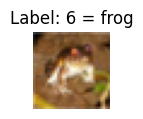

In [118]:
# Example to reshape one image
first_image_flat = train_data['image'][0]
first_image = np.array(first_image_flat).reshape(3, 32, 32).transpose(1, 2, 0)

# Set a smaller figure size, I cant seeeeee please zoom out!
plt.figure(figsize=(1, 1))  
plt.imshow(first_image)
plt.title(f'Label: {train_data['label'][0]} = {DIRECTORY_LABELS[train_data['label'][0]]}')
plt.axis('off')  # Optional: turn off axis
plt.show()

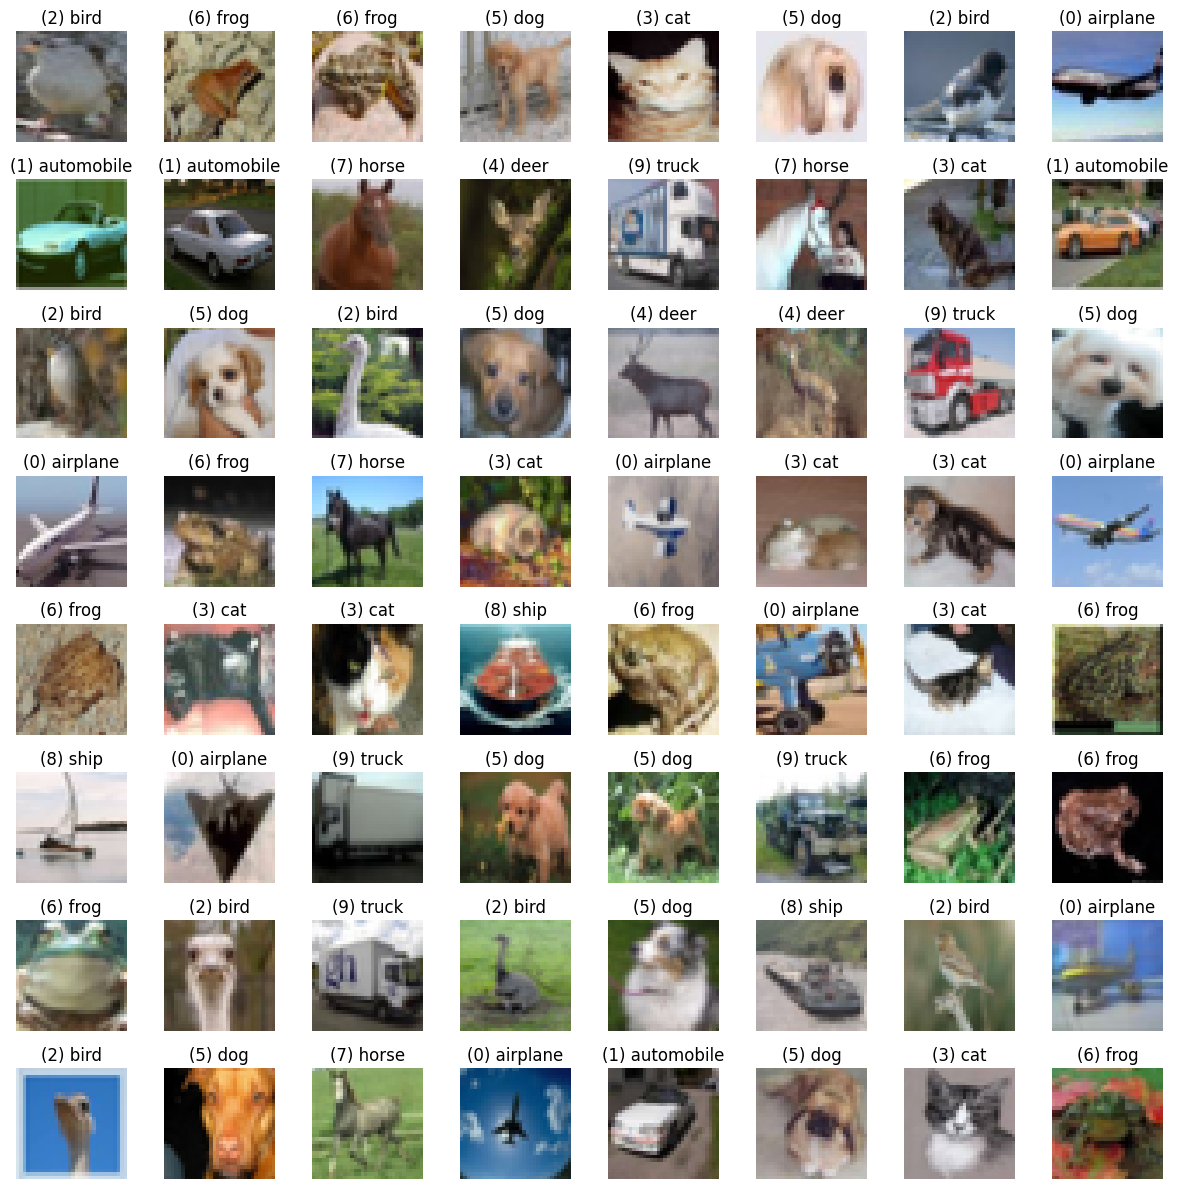

In [119]:
# Select 64 random indices from the dataset
random_indices = np.random.choice(train_data.index, size=64, replace=False)

# Set the size of the grid
plt.figure(figsize=(12, 12))

# Loop through the selected indices
for i, index in enumerate(random_indices):
    # Get the image and label
    image_flat = train_data.loc[index, 'image']
    label_number = train_data.loc[index, 'label']
    class_name = DIRECTORY_LABELS[label_number]

    # Reshape the image
    image = np.array(image_flat).reshape(3, 32, 32).transpose(1, 2, 0)
    title = f"({label_number}) {class_name}"
    # Plot the image on a grid
    plt.subplot(8, 8, i + 1)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

### 1) Data preprocessing: Normalize and augmentate data
- Normalize the data: This ensures that all your features (pixel values) are on the same scale, which helps in faster convergence by preventing any single feature from dominating the others.
- Apply data augmentation to your training set to create additional, diverse samples that can help the model generalize better.
- Augmentation: only occurs during training to increase the variability of the input data. You should avoid applying these transformations to the validation or test set because it would artificially alter the data you're using to evaluate performance.

In [120]:
# Normalize the images to be between 0 and 1
train_images_normalized = train_images / 255.0
test_images_normalized = test_images / 255.0

In [121]:
# Define a simple augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    # tf.keras.layers.RandomContrast(0.1),
    # tf.keras.layers.RandomBrightness(0.1)
])

### 2) Model Architecture: Starting with a Simple CNN
Convolutional Layer: This layer applies convolution operations to extract features from the input images. The filters (or "kernels") in these layers learn spatial hierarchies of data (like edges and textures).

Pooling Layer: Typically, max pooling layers downsample the spatial dimensions (i.e., width and height) of the feature maps. This reduces the number of parameters, and computations, and can help control overfitting.

Fully Connected Layer (Dense Layer): After flattening the pooled feature maps, these layers capture relationships across the entire input to make predictions. This part of the network typically connects information from all the learned features and models it towards the label of the image.

Output Layer: In multi-class classification, it will use softmax activation to produce probabilities for each class, which sum up to 1.

In [122]:
# Define the model with an Input layer
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    
    # tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the updated model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model’s summary
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [123]:
# Split the data (80% training, 20% validation)
train_images, val_images, train_labels, val_labels = train_test_split(train_images_normalized, train_labels, test_size=0.2, random_state=42)

# Reshape validation images
val_images = val_images.reshape(-1, 32, 32, 3)  # -1 ensures it calculates the number of samples automatically

# Create the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(32)

In [124]:
print(val_images.shape)  # Expected shape: (10000, 32, 32, 3)

for images, labels in val_dataset.take(1):
    print(images.shape)  # Expected: (64, 32, 32, 3) for the first batch

(10000, 32, 32, 3)
(32, 32, 32, 3)


In [125]:
# Define the function to reshape and augment images
def augment_image(x, y):
    # Reshape x from flattened (32*32*3 = 3072) to (32, 32, 3)
    x = tf.reshape(x, (32, 32, 3))
    # Apply the data augmentation pipeline. When using map, this simulates augmentation per instance
    x = data_augmentation(x)
    return x, y

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Create a dataset from your training images and labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

# Apply reshaping and augmentation
train_dataset = train_dataset.map(augment_image)

# Shuffle and batch the dataset correctly
train_dataset = train_dataset.shuffle(50000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

for images, labels in train_dataset.take(1):
    print(images.shape)  # Should output (batch_size, 32, 32, 3)

# Train the model with early stopping
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10, 
                    callbacks=[early_stopping, reduce_lr])

(32, 32, 32, 3)
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.2155 - loss: 2.1024 - val_accuracy: 0.2758 - val_loss: 1.9907 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.2987 - loss: 1.9181 - val_accuracy: 0.3176 - val_loss: 1.8751 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.3307 - loss: 1.8399 - val_accuracy: 0.3607 - val_loss: 1.7444 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.3447 - loss: 1.8012 - val_accuracy: 0.3715 - val_loss: 1.7204 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.3571 - loss: 1.7695 - val_accuracy: 0.3792 - val_loss: 1.6955 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.3638 - loss: 1.7520 - val_accuracy: 0.3590 - val_loss: 1.7617 - learning_rate: 0.0010
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 14

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


<Figure size 1000x800 with 0 Axes>

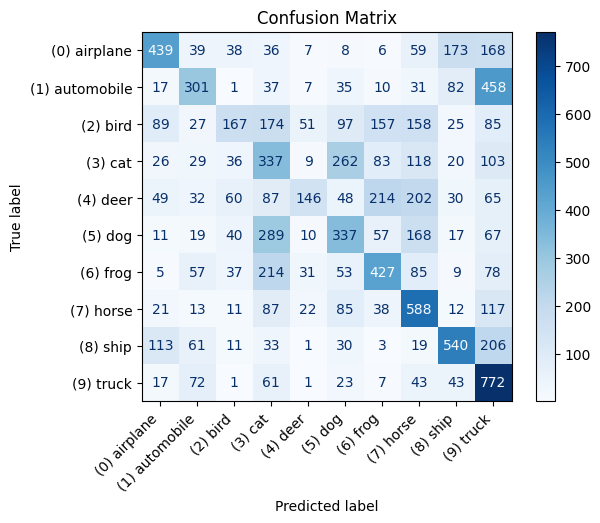

In [126]:
# Function to format label names with indices
def format_labels_with_indices(labels_dict):
    return [f"({index}) {name}" for index, name in labels_dict.items()]

# Get the formatted labels
formatted_labels = format_labels_with_indices(DIRECTORY_LABELS)

# Make predictions on the validation dataset
val_predictions = model.predict(val_dataset)
# Convert predictions to class labels
val_predictions = np.argmax(val_predictions, axis=1)

# Extract the true labels
val_labels = np.concatenate([y for _, y in val_dataset], axis=0)

# Create the confusion matrix
cm = confusion_matrix(val_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
cmp = ConfusionMatrixDisplay(cm, display_labels=formatted_labels)
cmp.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=45, ha="right")  # Rotate x labels for readability
plt.title('Confusion Matrix')
plt.show()

Training Accuracy:  [0.21552500128746033, 0.298675000667572, 0.3307499885559082, 0.34474998712539673, 0.3570750057697296, 0.36375001072883606, 0.3718000054359436, 0.37867501378059387, 0.3843500018119812, 0.38839998841285706]
Validation Accuracy:  [0.2757999897003174, 0.3176000118255615, 0.36070001125335693, 0.3714999854564667, 0.3792000114917755, 0.35899999737739563, 0.40540000796318054, 0.3797999918460846, 0.376800000667572, 0.40639999508857727]


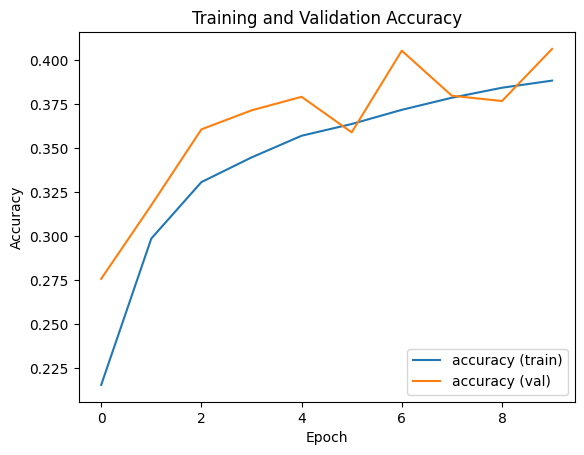

In [127]:
print("Training Accuracy: ", history.history['accuracy'])
print("Validation Accuracy: ", history.history['val_accuracy'])

plt.plot(history.history['accuracy'], label='accuracy (train)')
plt.plot(history.history['val_accuracy'], label='accuracy (val)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()